This product includes GeoLite data created by MaxMind, available from 
<a href="http://www.maxmind.com">http://www.maxmind.com</a>.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
import pylab
import subprocess
import netifaces
from __future__ import unicode_literals
from StringIO import StringIO
from sh import tail
from scapy.all import *
from mpl_toolkits.basemap import Basemap as Basemap
%matplotlib inline

pylab.rcParams['figure.figsize'] = (18.0, 18.0)

water_color = '#E0FFFF'
land_color = '#93C572'

### my_coordinates powinna zawierać nasze współrzędne geograficzne
my_coordinates = (52.132251, 21.033101)

### my_interface powinien zawierać nazwę interfejsu z którego korzystamy
my_interface = "wlan0"
netifaces.ifaddresses(my_interface)
my_ip = netifaces.ifaddresses(my_interface)[2][0]['addr']
my_ip_prefix = my_ip.split(".")[0]

log_address = "/var/log/syslog"

In [2]:
### bazy powinny znajdować się w tym samym folderze, co ten program
data = pa.read_csv("GeoLiteCity-Blocks.csv", skiprows=1, low_memory=False)
data2 = pa.read_csv("GeoLiteCity-Location.csv", skiprows=1, low_memory=False)

In [3]:
def convert_ip(ip):
    """
        Konwertuje adres ip z formatu "X.X.X.X" na liczbę szukalną w bazie
    """
    o1, o2, o3, o4 = ip.split('.')
    if o1 == my_ip_prefix:
        return -1
    return 16777216 * int(o1) + 65536 * int(o2) + 256 * int(o3) + int(o4)

In [4]:
def get_route(whereto, ttl=32, www=False):
    """
        Zwraca ścieżkę adresów ip znalezioną przez tracerouta
        'whereto' to koniec ścieżki
        'ttl' to Time To Live
        www to bool oznaczający, czy whereto jest adresem www
    """
    if www:
        whereto = socket.gethostbyname(whereto)
    target = [whereto]
    result, unans = traceroute(target,maxttl=ttl)
    path = []
    for i in xrange(len(result)):
        a, b = result[i]
        capture = StringIO()
        save_stdout = sys.stdout
        sys.stdout = capture
        b.show()
        sys.stdout = save_stdout
        c = capture.getvalue()
        path.append(c.split("\n")[11].split("= ")[1])
    while (len(path) >= 2) and (path[-1] == path[-2]):
        path.pop()
    return path

In [5]:
def get_loc(ip):
    """
        Zwraca wyciągnięte z bazy współrzędne geograficzne adresu ip
    """
    if not isinstance(ip, int):
        ip = convert_ip(ip)
    if ip == -1:
        return my_coordinates
    pocz = 0
    kon = len(data)
    while pocz + 1 < kon:
        mid = (pocz + kon) // 2
        a = data["startIpNum"][mid]
        b = data["endIpNum"][mid]
        if a > ip:
            kon = mid
        elif b < ip:
            pocz = mid + 1
        else:
            pos = data["locId"][mid] - 1
            return (data2["latitude"][pos], data2["longitude"][pos])
    
    pos = data["locId"][pocz] - 1
    return (data2["latitude"][pos], data2["longitude"][pos])

In [6]:
def parse_log(log):
    """
        Parsuje loga dostarczonego przez iptables
        Zwraca adres ip do którego wchodzimy
    """
    try:
        if log.find("wlan0") == -1 or log.find("kernel") == -1:
            return None
    except:
        return None
    
    l = log.split(" ")
    od = ""
    do = ""
    for s in l:
        if s.find("SRC=") != -1:
            od = s[4:]
        if s.find("DST=") != -1:
            do = s[4:]
    if od[:len(my_ip_prefix)] != my_ip_prefix:
        return None
    return do

In [7]:
def get_logs(ile):
    """
        Odpala iptables i czyta sysloga aż zbierze 'ile' sensownych destynacji
        Zwraca listę adresów ip
    """
    test1 = subprocess.Popen(["iptables", "-I", "INPUT", "1", "-j", "LOG"], stdout=subprocess.PIPE)
    output1 = test1.communicate()[0]
    test2 = subprocess.Popen(["iptables", "-I", "OUTPUT", "1", "-j", "LOG"], stdout=subprocess.PIPE)
    output2 = test2.communicate()[0]
    
    logi = []
    for line in tail("-f", log_address, _iter=True):
        l = parse_log(line)
        if l is not None:
            logi.append(l)
            ile -= 1
            if ile == 0:
                print "Skończyłem czytać sysloga"
                break
    
    test = subprocess.Popen(["iptables", "-D", "INPUT", "1"], stdout=subprocess.PIPE)
    output = test.communicate()[0]
    test = subprocess.Popen(["iptables", "-D", "OUTPUT", "1"], stdout=subprocess.PIPE)
    output = test.communicate()[0]
    return logi

In [8]:
def get_graph(ile=10, ttl=32):
    """
        Zbiera 'ile' logów używając funkcji 'get_logs', a następnie do każdego znalezionego
        adresu ip znajduje ścieżkę traceroutem. Później z tych ścieżek tworzy graf, wszystkie 
        znalezione adresy zamienia na współrzędne geograficzne i to zwraca.
    """
    lats = []
    lons = []
    ipki = {}
    vertex_nr = 0
    G = nx.DiGraph()

    logi = get_logs(ile)
    paths = []
    
    for do in logi:
        path = get_route(do, ttl)
        paths.append(path)
        for q in path:
            if not (q in ipki):
                ipki[q] = vertex_nr
                vertex_nr += 1
                la, lo = get_loc(q)
                lats.append(la)
                lons.append(lo)
        for i in xrange(len(path) - 1):
            G.add_edge(ipki[path[i]], ipki[path[i + 1]])
    
    return (G, lons, lats)

In [9]:
def rysuj(G, lons, lats, area=None, savefile=None):
    """
        Rysuje na mapie graf G z podanymi listami długości oraz szerokości geograficznych.
        Jeśli area przyjmie stringa "Europe", to mapka pokazuje Europę.
        Jeśli savefile jest stringiem, to zapisuje rysunek do pliku o takiej nazwie.
    """
    if area == "Europe":
        m = Basemap(projection='merc',
                    llcrnrlon=-30,
                    llcrnrlat=25,
                    urcrnrlon=70,
                    urcrnrlat=65)
    if area is None or area == "World":
        m = Basemap(projection='merc',
                    llcrnrlon=-180,
                    llcrnrlat=-80,
                    urcrnrlon=180,
                    urcrnrlat=80)

    mx, my = m(lons, lats)
    pos = {}
    for i in xrange(len(lats)):
        pos[i] = (mx[i], my[i])
    sizes = [10 for x in pos]
    sizes[0] *= 2
    
    m.drawcountries(linewidth=0.2)
    m.drawcoastlines(linewidth=0.1)
    m.drawstates(linewidth=0.03)
    m.drawmapboundary(fill_color=water_color)
    m.fillcontinents(color=land_color, lake_color=water_color, alpha=1, zorder=0)
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="black")
    nodes.set_edgecolor('brown')
    nx.draw_networkx_edges(G, pos, edge_color="brown", width=0.4, arrows=True)
    plt.title("Jan pakiet drugi lubił małe podróże")
    if type(savefile) == unicode:
        plt.savefig(savefile, dpi=200)
    plt.show()

In [14]:
G, lons, lats = get_graph(50)

Skończyłem czytać sysloga

Received 34 packets, got 31 answers, remaining 1 packetsBegin emission:
Finished to send 32 packets.

   200.89.76.16:tcp80 
1  192.168.8.1     11 
3  10.220.92.82    11 
4  10.220.92.122   11 
5  212.2.102.201   11 
6  212.2.102.174   11 
7  213.248.76.33   11 
8  80.91.251.215   11 
9  62.115.142.17   11 
10 213.248.72.10   11 
11 129.250.5.217   11 
12 129.250.3.20    11 
13 129.250.3.85    11 
14 129.250.2.87    11 
15 129.250.2.185   11 
16 131.103.116.146 11 
17 190.208.9.81    11 
18 190.208.9.10    11 
19 200.27.101.242  11 
20 200.89.75.35    11 
21 200.89.76.16    11 
22 200.89.76.16    11 
23 200.89.76.16    SA 
24 200.89.76.16    SA 
25 200.89.76.16    SA 
26 200.89.76.16    SA 
27 200.89.76.16    SA 
28 200.89.76.16    SA 
29 200.89.76.16    SA 
30 200.89.76.16    SA 
31 200.89.76.16    SA 
32 200.89.76.16    SA 

Received 32 packets, got 31 answers, remaining 1 packetsBegin emission:
Finished to send 32 packets.

   212.193.33.27:tcp80 
1  192.1

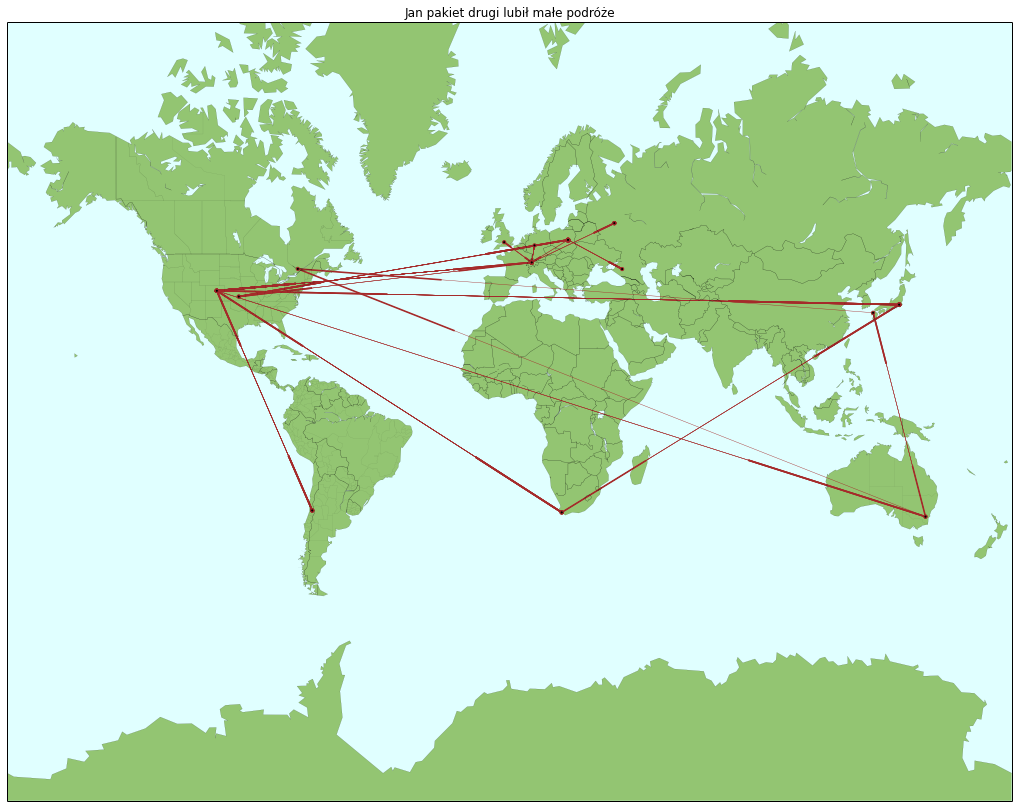

In [15]:
rysuj(G, lons, lats)

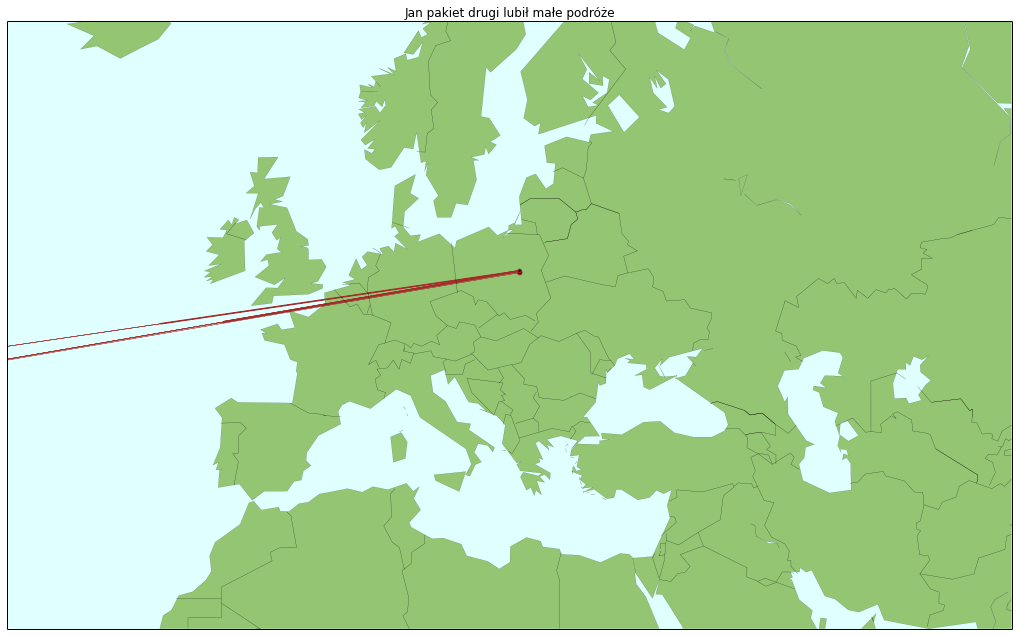

In [13]:
rysuj(G, lons, lats, area="Europe")